<a href="https://colab.research.google.com/github/surya323-ma/Stock-Mrket-Forecsting-Tool-project/blob/main/Stock_Mrket_Forecsting_Tool_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd

In [2]:
from cryptography.fernet import Fernet

# Generate a key for encryption
key = Fernet.generate_key()
cipher_suite = Fernet(key)

# Encrypt data
def encrypt_data(data):
    return cipher_suite.encrypt(data.encode())

# Decrypt data
def decrypt_data(encrypted_data):
    return cipher_suite.decrypt(encrypted_data).decode()

In [ ]:
!pip install boto3

In [3]:
import boto3

# Initialize S3 client
s3 = boto3.client('s3')

# Upload encrypted data to S3
def upload_to_s3(bucket_name, file_name, data):
    s3.put_object(Bucket=bucket_name, Key=file_name, Body=data)

# Download encrypted data from S3
def download_from_s3(bucket_name, file_name):
    response = s3.get_object(Bucket=bucket_name, Key=file_name)
    return response['Body'].read()

ModuleNotFoundError: No module named 'boto3'

In [4]:
import yfinance as yf
import pandas as pd

# Function to fetch historical stock data
def fetch_historical_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Example usage
ticker = 'AAPL'
data = fetch_historical_data(ticker, '2020-01-01', '2023-01-01')
data = data[['Close']]  # We will use only the closing prices
data.reset_index(inplace=True)
print(data.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price        Date      Close
Ticker                  AAPL
0      2020-01-02  72.716064
1      2020-01-03  72.009102
2      2020-01-06  72.582901
3      2020-01-07  72.241547
4      2020-01-08  73.403648


In [5]:
# Fill missing values
data['Close'].fillna(method='ffill', inplace=True)

# Normalize the data
data['Close'] = (data['Close'] - data['Close'].mean()) / data['Close'].std()

<ipython-input-5-9010391bab36>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Close'].fillna(method='ffill', inplace=True)
<ipython-input-5-9010391bab36>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Close'].fillna(method='ffill', inplace=True)


In [6]:
def create_features(data, lag=1):
    for i in range(1, lag + 1):
        data[f'lag_{i}'] = data['Close'].shift(i)
    return data.dropna()

data = create_features(data, lag=5)
print(data.head())

Price        Date     Close     lag_1     lag_2     lag_3     lag_4     lag_5
Ticker                 AAPL                                                  
5      2020-01-09 -1.734580 -1.785765 -1.823915 -1.812709 -1.831546 -1.808337
6      2020-01-10 -1.729017 -1.734580 -1.785765 -1.823915 -1.812709 -1.831546
7      2020-01-13 -1.676322 -1.729017 -1.734580 -1.785765 -1.823915 -1.812709
8      2020-01-14 -1.710339 -1.676322 -1.729017 -1.734580 -1.785765 -1.823915
9      2020-01-15 -1.720989 -1.710339 -1.676322 -1.729017 -1.734580 -1.785765


In [7]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['Close'])
y = data['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<ipython-input-7-a92b50f9b6de>:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = data.drop(columns=['Close'])


In [9]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Train XGBoost model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror')
# Before fitting the model, drop the 'Date' column from X_train if it exists
X_train = X_train.select_dtypes(include=['number'])
X_test = X_test.select_dtypes(include=['number'])  # Do the same for X_test
model_xgb.fit(X_train, y_train)

# Predictions
y_pred_xgb = model_xgb.predict(X_test)
print("XGBoost MSE:", mean_squared_error(y_test, y_pred_xgb))

XGBoost MSE: 0.013952684588730335


In [10]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Reshape data for LSTM
X_train_lstm = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(50))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train_lstm, y_train, epochs=50, batch_size=32)

# Predictions
y_pred_lstm = model_lstm.predict(X_test_lstm)
print("LSTM MSE:", mean_squared_error(y_test, y_pred_lstm))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.7460
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0744
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0321
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0253
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0239
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0223
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0249
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0259
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0260
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0238
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0266
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0214
Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0247
Epoch 14/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0223
Epoch 15/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0220
Epoch 16/50
19/19 ━━━━━━━━━━━━

<Figure size 1400x700 with 0 Axes>

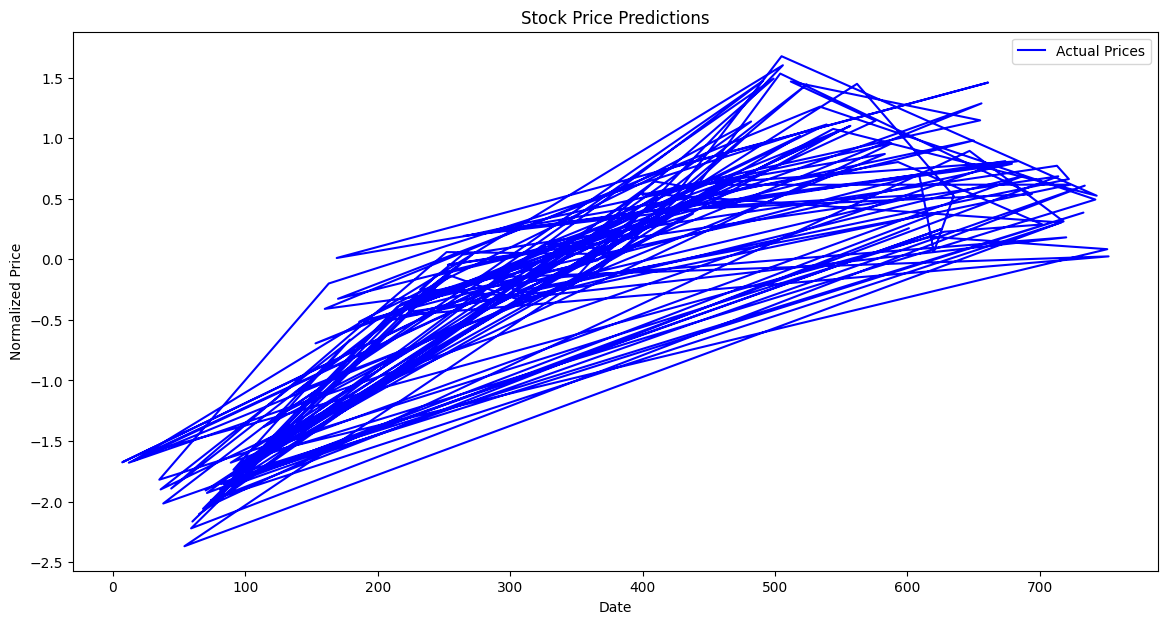

In [11]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(14, 7))
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Prices', color='blue')
plt.title('Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()

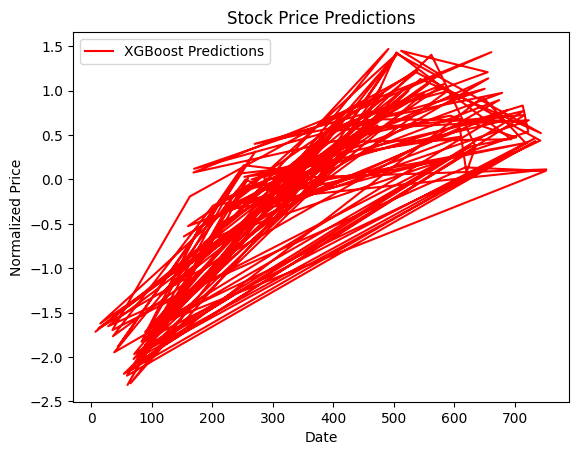

In [12]:

plt.plot(y_test.index, y_pred_xgb, label='XGBoost Predictions', color='red')
plt.title('Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()

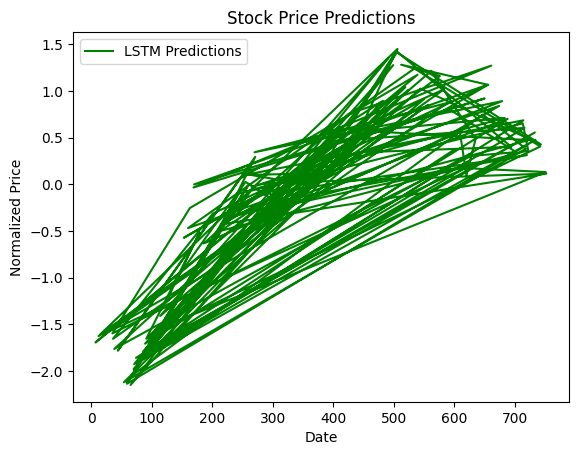

In [13]:
plt.plot(y_test.index, y_pred_lstm, label='LSTM Predictions', color='green')
plt.title('Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()

In [14]:
def fetch_live_data(ticker):
    live_data = yf.download(ticker, period='1d', interval='1m')
    return live_data['Close'].iloc[-1]

# Example usage
live_price = fetch_live_data(ticker)
print(f"Live Price for {ticker}: {live_price}")

[*********************100%***********************]  1 of 1 completed

Live Price for AAPL: Ticker
AAPL    188.380005
Name: 2025-04-04 19:59:00+00:00, dtype: float64


In [15]:
!pip install schedule

In [ ]:
import schedule
import time

def job():
    print("Fetching live data...")
    live_price = fetch_live_data(ticker)
    print(f"Live Price for {ticker}: {live_price}")

# Schedule the job every minute
schedule.every(1).minutes.do(job)

while True:
    schedule.run_pending()
    time.sleep(1)

[*********************100%***********************]  1 of 1 completed

Fetching live data...
Live Price for AAPL: Ticker
AAPL    188.380005
Name: 2025-04-04 19:59:00+00:00, dtype: float64



[*********************100%***********************]  1 of 1 completed

Fetching live data...
Live Price for AAPL: Ticker
AAPL    188.380005
Name: 2025-04-04 19:59:00+00:00, dtype: float64



[*********************100%***********************]  1 of 1 completed

Fetching live data...
Live Price for AAPL: Ticker
AAPL    188.380005
Name: 2025-04-04 19:59:00+00:00, dtype: float64



[*********************100%***********************]  1 of 1 completed

Fetching live data...
Live Price for AAPL: Ticker
AAPL    188.380005
Name: 2025-04-04 19:59:00+00:00, dtype: float64



[*********************100%***********************]  1 of 1 completed

Fetching live data...
Live Price for AAPL: Ticker
AAPL    188.380005
Name: 2025-04-04 19:59:00+00:00, dtype: float64



[*********************100%***********************]  1 of 1 completed

Fetching live data...
Live Price for AAPL: Ticker
AAPL    188.380005
Name: 2025-04-04 19:59:00+00:00, dtype: float64



[*********************100%***********************]  1 of 1 completed

Fetching live data...
Live Price for AAPL: Ticker
AAPL    188.380005
Name: 2025-04-04 19:59:00+00:00, dtype: float64



[*********************100%***********************]  1 of 1 completed

Fetching live data...
Live Price for AAPL: Ticker
AAPL    188.380005
Name: 2025-04-04 19:59:00+00:00, dtype: float64



[*********************100%***********************]  1 of 1 completed

Fetching live data...
Live Price for AAPL: Ticker
AAPL    188.380005
Name: 2025-04-04 19:59:00+00:00, dtype: float64



[*********************100%***********************]  1 of 1 completed

Fetching live data...
Live Price for AAPL: Ticker
AAPL    188.380005
Name: 2025-04-04 19:59:00+00:00, dtype: float64



[*********************100%***********************]  1 of 1 completed

Fetching live data...
Live Price for AAPL: Ticker
AAPL    188.380005
Name: 2025-04-04 19:59:00+00:00, dtype: float64



[*********************100%***********************]  1 of 1 completed

Fetching live data...
Live Price for AAPL: Ticker
AAPL    188.380005
Name: 2025-04-04 19:59:00+00:00, dtype: float64



[*********************100%***********************]  1 of 1 completed

Fetching live data...
Live Price for AAPL: Ticker
AAPL    188.380005
Name: 2025-04-04 19:59:00+00:00, dtype: float64



[*********************100%***********************]  1 of 1 completed

Fetching live data...
Live Price for AAPL: Ticker
AAPL    188.380005
Name: 2025-04-04 19:59:00+00:00, dtype: float64



[*********************100%***********************]  1 of 1 completed

Fetching live data...
Live Price for AAPL: Ticker
AAPL    188.380005
Name: 2025-04-04 19:59:00+00:00, dtype: float64



[*********************100%***********************]  1 of 1 completed

Fetching live data...
Live Price for AAPL: Ticker
AAPL    188.380005
Name: 2025-04-04 19:59:00+00:00, dtype: float64



[*********************100%***********************]  1 of 1 completed

Fetching live data...
Live Price for AAPL: Ticker
AAPL    188.380005
Name: 2025-04-04 19:59:00+00:00, dtype: float64



[*********************100%***********************]  1 of 1 completed

Fetching live data...
Live Price for AAPL: Ticker
AAPL    188.380005
Name: 2025-04-04 19:59:00+00:00, dtype: float64



[*********************100%***********************]  1 of 1 completed

Fetching live data...
Live Price for AAPL: Ticker
AAPL    188.380005
Name: 2025-04-04 19:59:00+00:00, dtype: float64


In [ ]:
import streamlit as st

st.title('Stock Market Forecasting Tool')

ticker = st.text_input('Enter Stock Ticker', 'AAPL')
if st.button('Fetch Data'):
    data = fetch_historical_data(ticker, '2020-01-01', '2023-01-01')
    st.line_chart(data['Close'])

In [ ]:
def compare_models(y_test, y_pred_xgb, y_pred_lstm):
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    mse_lstm = mean_squared_error(y_test, y_pred_lstm)
    return mse_xgb, mse_lstm

mse_xgb, mse_lstm = compare_models(y_test, y_pred_xgb, y_pred_lstm)
print(f"XGBoost MSE: {mse_xgb}, LSTM MSE: {mse_lstm}")

In [ ]:
forecast_days = st.number_input('Days to Forecast', min_value=1, max_value=30, value=5)
# Use this input in your prediction logic

In [ ]:
import smtplib
from email.mime.text import MIMEText

def send_email_alert(price):
    msg = MIMEText(f"Alert! The stock price has changed significantly: {price}")
    msg['Subject'] = 'Stock Price Alert'
    msg['From'] = 'your_email@example.com'
    msg['To'] = 'recipient@example.com'

    with smtplib.SMTP('smtp.example.com') as server:
        server.login('your_email@example.com', 'your_password')
        server.send_message(msg)

# Call this function when a significant price change is detected